<a href="https://colab.research.google.com/github/komorimasashi/time_series_book/blob/main/chapter6/Chapter_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 多変量時系列データの要約

In [20]:
#必要なパッケージのインストール
targetPackages <- c('dplyr','MARSS','fda') 
newPackages <- targetPackages[!(targetPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘misc3d’, ‘locfit’, ‘ash’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘plot3D’, ‘pracma’, ‘pcaPP’, ‘hdrcde’, ‘ks’, ‘bitops’, ‘rainbow’, ‘RCurl’, ‘fds’, ‘deSolve’




In [17]:
# 2022年6月時点でNMFの依存パッケージのインストールが
# うまく行かない問題があります．下記のソースを実行してみてください
if(any(installed.packages()[,1]== 'NMF') == FALSE){
  BiocManager::install('Biobase')
  install.packages('BiocManager')
  install.packages('NMF')
}

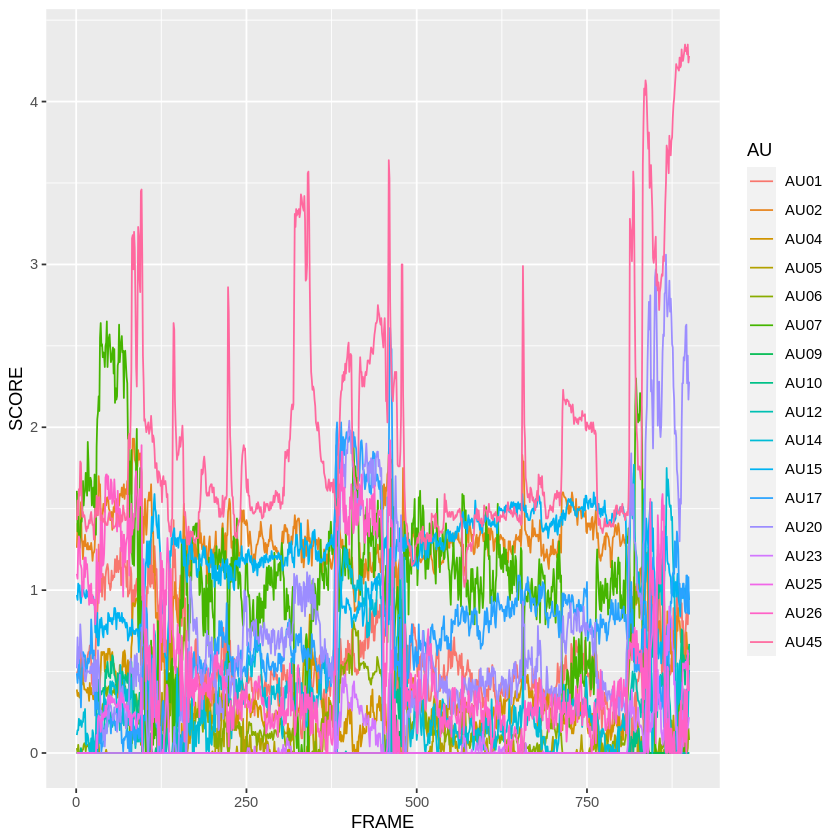

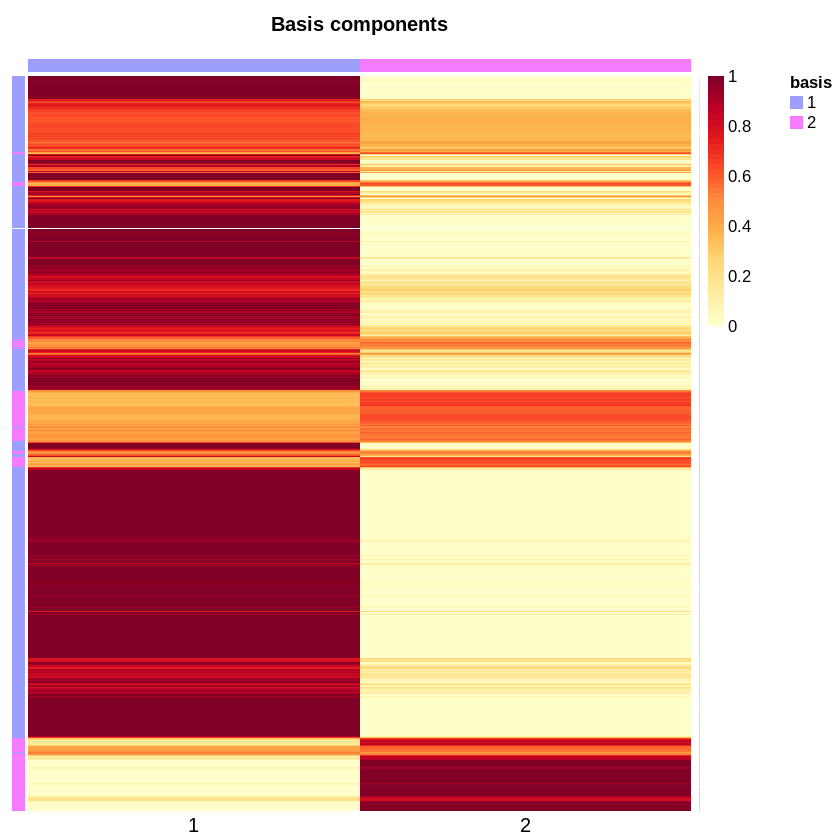

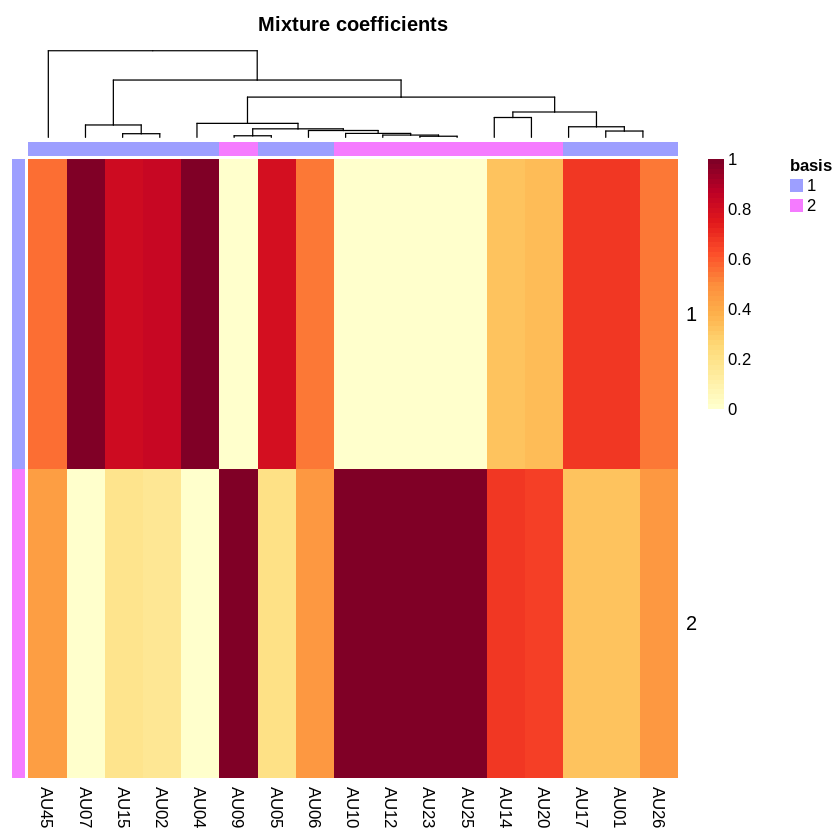

In [18]:
# 6.2 非負値行列因子分解

library(dplyr)
library(ggplot2)
library(NMF)

# 読み込むGoogleスプレッドシートのURLを設定
URL <- "https://raw.githubusercontent.com/komorimasashi/time_series_book/90f315f0ad38f18167f6de4366e0667dda3106ed/data/abe_facial_mov.csv"
# データの読み込み
dat <- read.csv(URL, header=T,fileEncoding = "shift-jis")
# データの準備
df <- data.frame("FRAME" = dat$frame,
                 "AU01" = dat$AU01_r, "AU02" = dat$AU02_r, "AU04"= dat$AU04_r,
                 "AU05" = dat$AU05_r, "AU06" = dat$AU06_r, "AU07" =dat$AU07_r,
                 "AU09" = dat$AU09_r, "AU10" = dat$AU10_r, "AU12" = dat$AU12_r,
                 "AU14" = dat$AU14_r, "AU15" = dat$AU15_r, "AU17" = dat$AU17_r,
                 "AU20" = dat$AU20_r, "AU23" = dat$AU23_r, "AU25" = dat$AU25_r,
                 "AU26" =dat$AU26_r, "AU45" =dat$AU45_r)
# プロット
df2 <- df %>% tidyr::gather(key=AU, value = SCORE, colnames(df)[-1])
g <- ggplot(df2, aes(x = FRAME, y = SCORE, color = AU))+ geom_line()
plot(g)

# NMFの実行
library(NMF)
res <- nmf(df[-1], rank = 2, seed = 1234, .options = "t")
basismap(res, Rowv=NA) # 'Rowv=NA'とすることで時系列順に表示されます
coefmap(res)


Success! abstol and log-log tests passed at 517 iterations.
Alert: conv.test.slope.tol is 0.5.
Test with smaller values (<0.1) to ensure convergence.

MARSS fit is
Estimation method: kem 
Convergence test: conv.test.slope.tol = 0.5, abstol = 0.001
Estimation converged in 517 iterations. 
Log-likelihood: -806.8518 
AIC: 1647.704   AICc: 1648.657   
 
                            Estimate
Z.11                          0.4623
Z.21                          0.6018
Z.31                          0.5148
Z.41                          0.3145
Z.51                          0.2210
Z.22                          0.3939
Z.32                         -0.2466
Z.42                         -0.0866
Z.52                         -0.6278
Z.33                          0.0786
Z.43                         -0.1536
Z.53                          0.1878
R.(Cryptomonas,Cryptomonas)   0.6064
R.(Diatoms,Diatoms)           0.2555
R.(Cyclops,Cyclops)           0.3890
R.(Unicells,Unicells)         0.3862
R.(Epischura,Episch

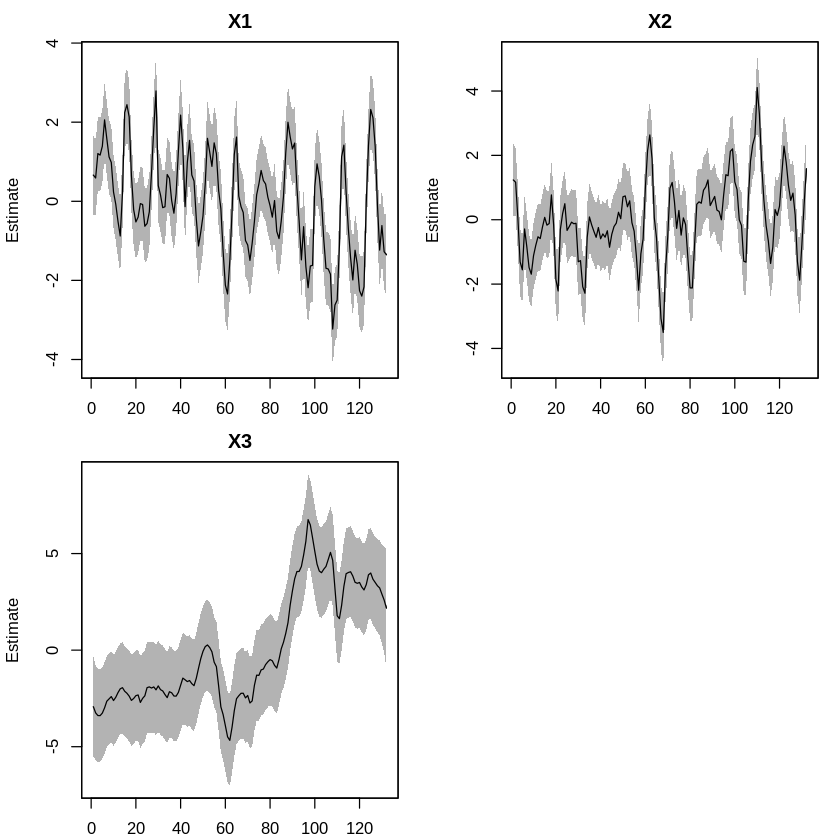

plot type =  fitted.ytT  Observations with fitted values


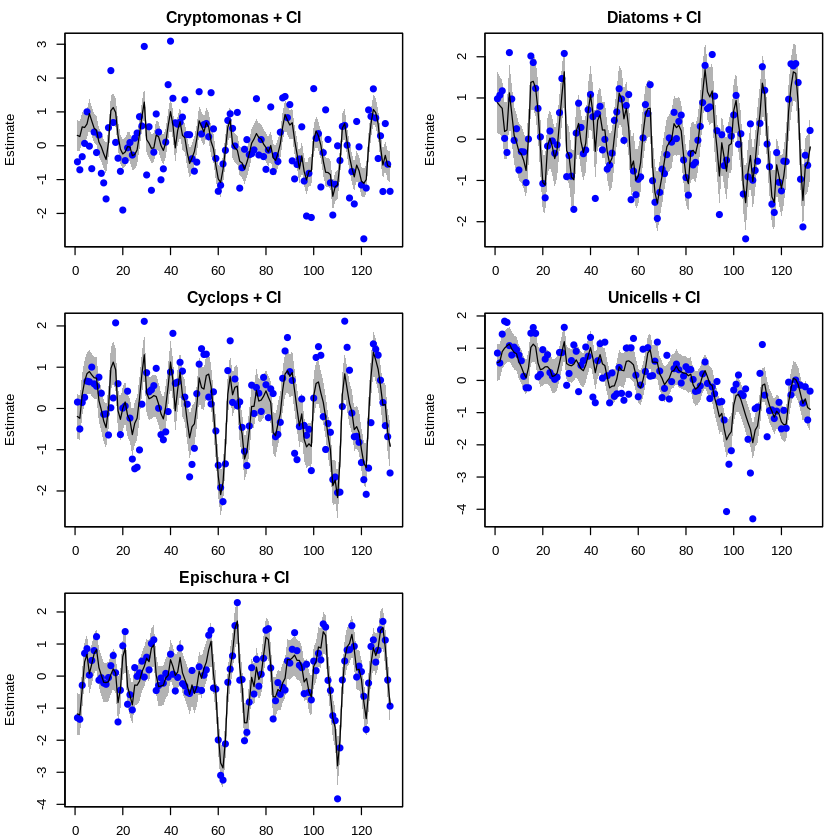

In [19]:
# 6.3 動的因子分析

library(MARSS)

data(lakeWAplankton)
plankdat <- lakeWAplanktonTrans
# 1980年から1990年までのプランクトンの量のデータを抜き出す
dat <- plankdat[1980<=plankdat[,"Year"] & plankdat[,"Year"]<=1990,
                c("Cryptomonas", "Diatoms","Cyclops","Unicells", "Epischura")]
# 時刻が列に対応するように転置する
dat <- t(dat)

# DFAの実行(RおよびQのモデルを設定する)
model.list = list(m=3, R="diagonal and unequal", Q="identity")
fit <- MARSS(dat, model=model.list, z.score=TRUE,
             form="dfa", control=list(maxit=3000))

# 結果の概要（Zは因子負荷量，Rは観測誤差の推定値が示される）
# 因子得点fはfit$statesに入っている
summary(fit)
# 推定された状態f_tのグラフ
plot(fit, plot.type = "xtT")
# 観測値と観測値の予測平均値とCIのグラフ
plot(fit, plot.type = "fitted.ytT")


Loading required package: splines

Loading required package: fds

Loading required package: rainbow

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: pcaPP

Loading required package: RCurl

Loading required package: deSolve


Attaching package: ‘fda’


The following object is masked from ‘package:graphics’:

    matplot




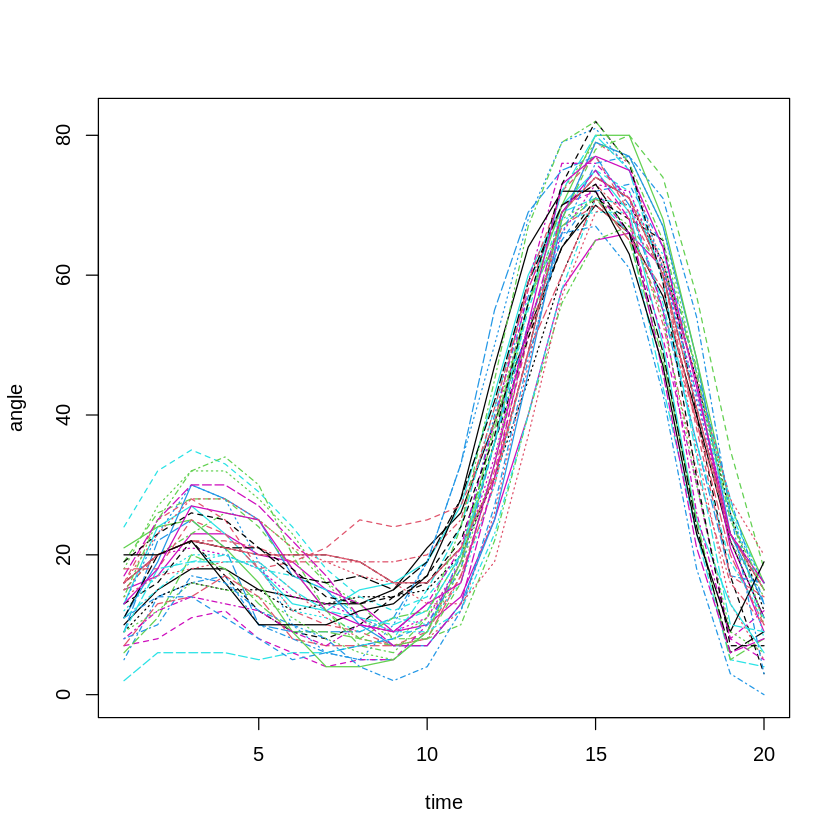

[1] "done"

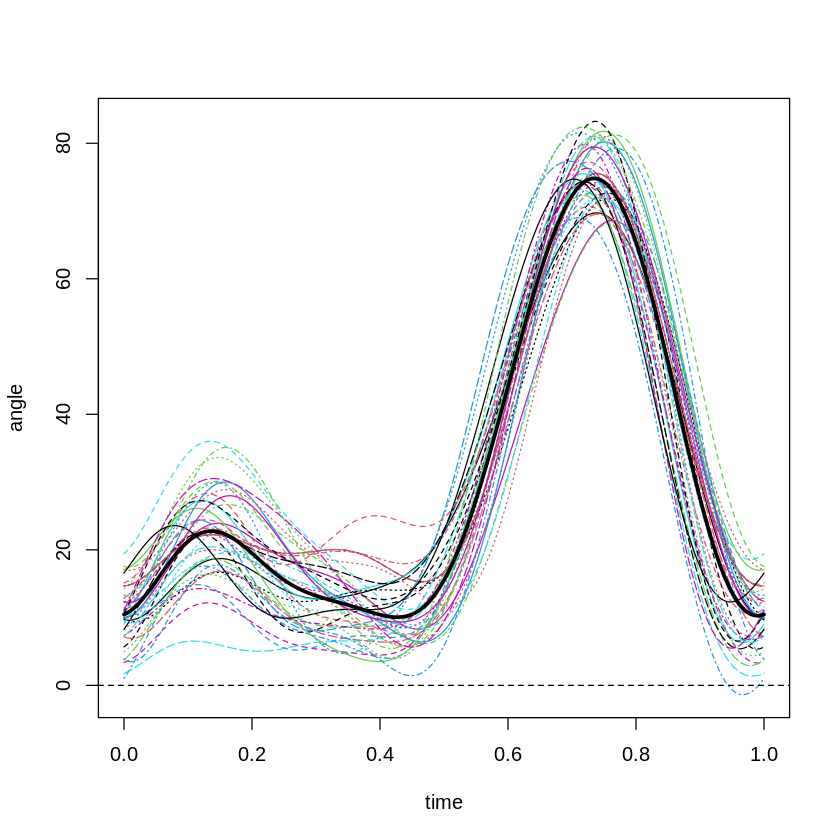

[1] "done"

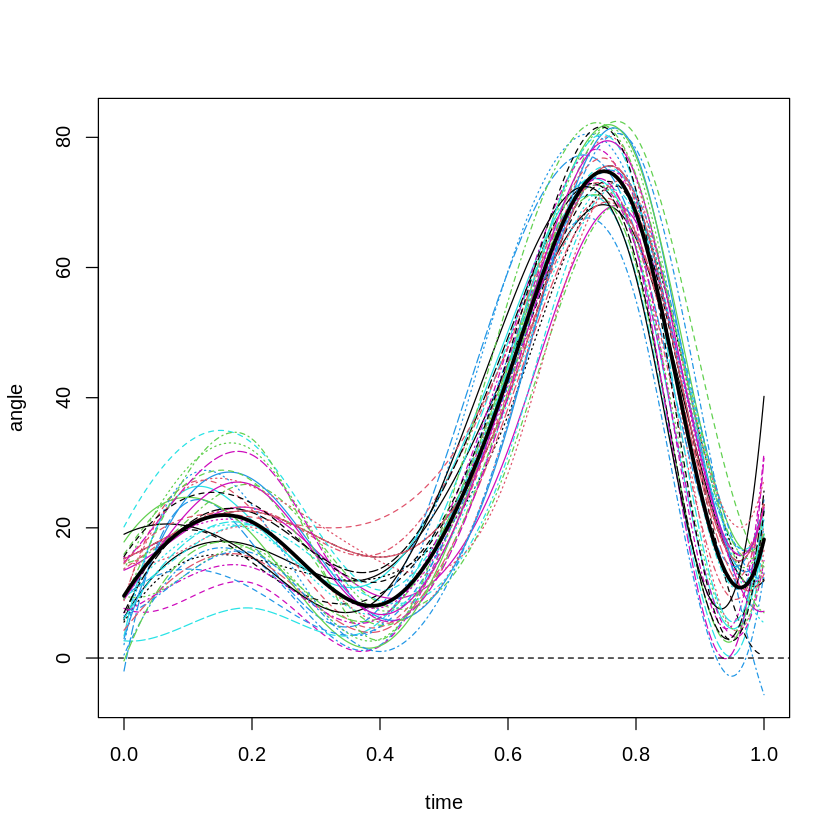

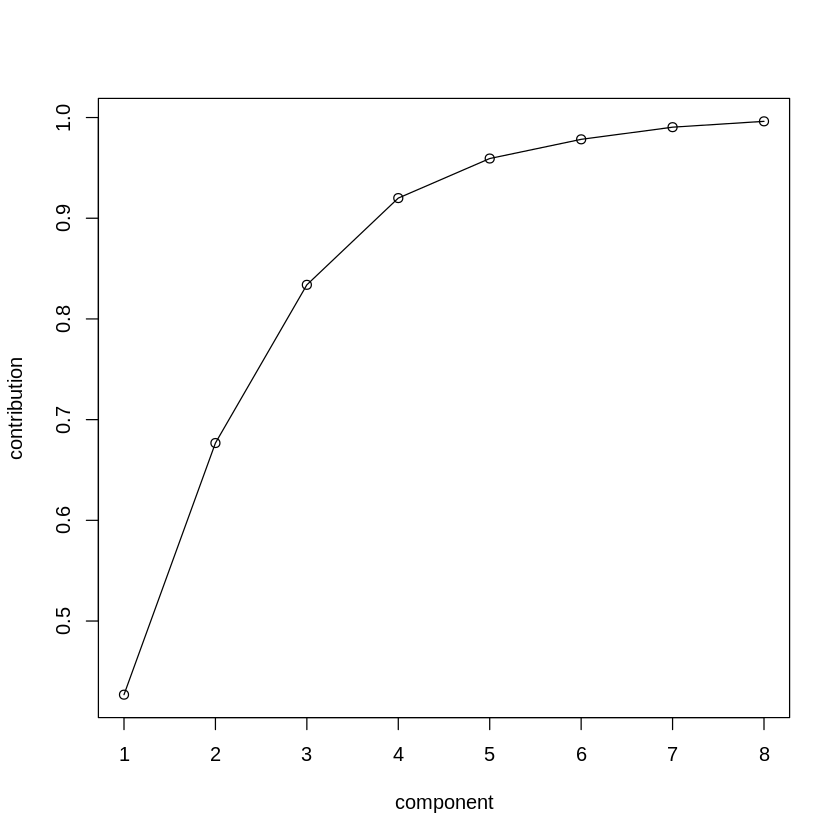

[1] "done"

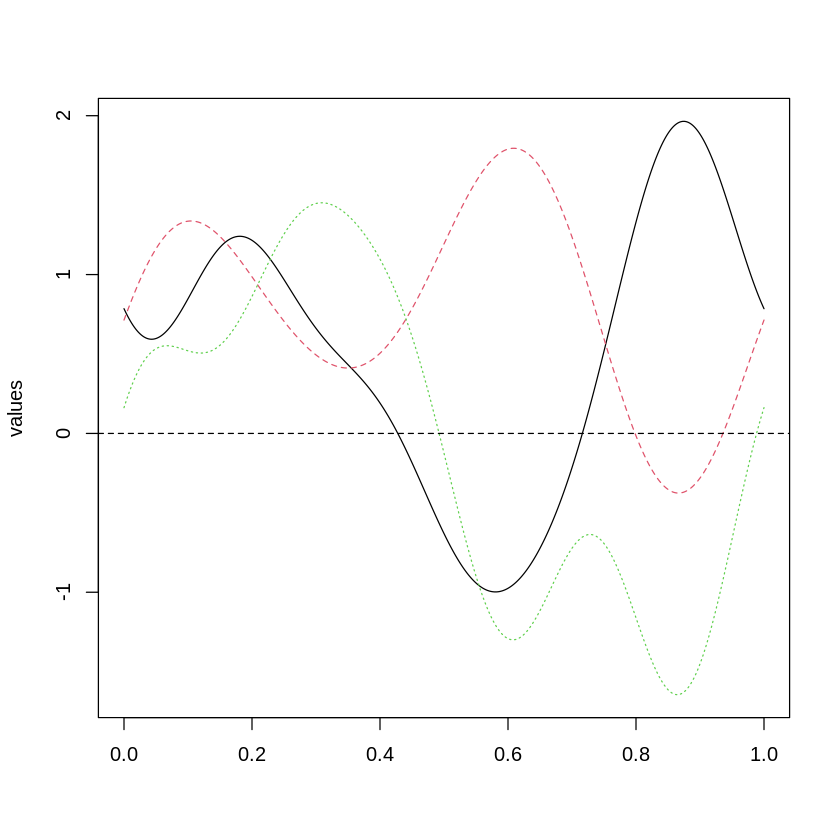

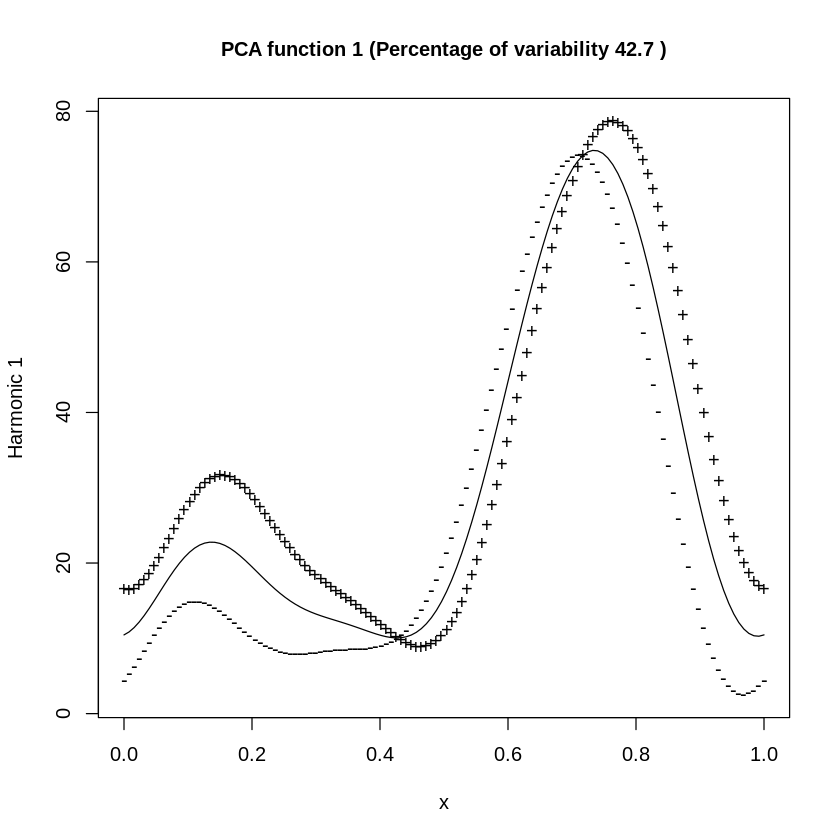

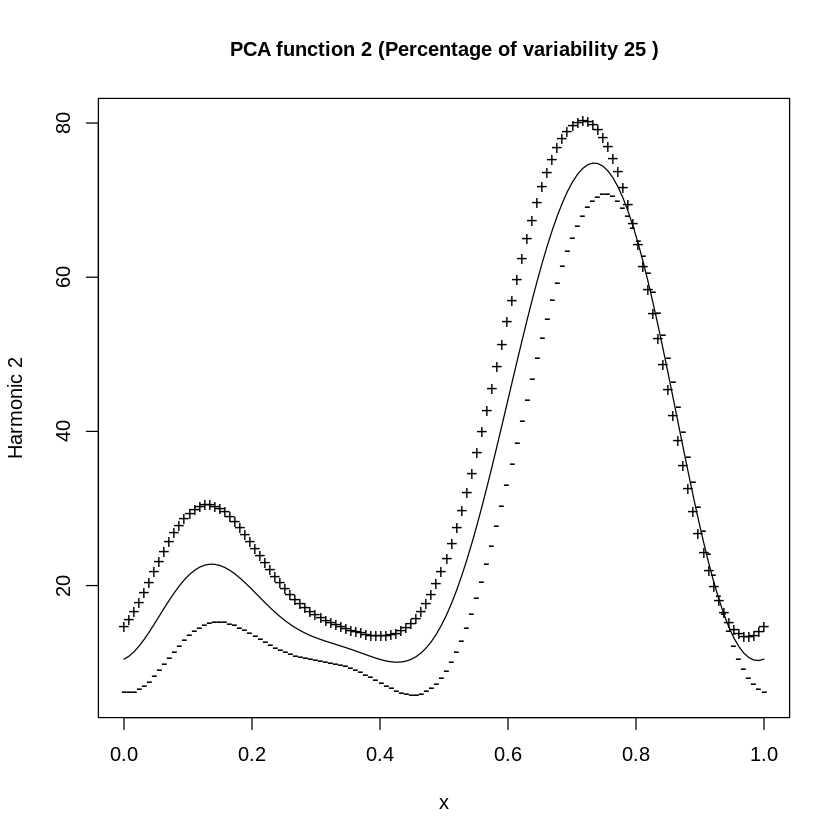

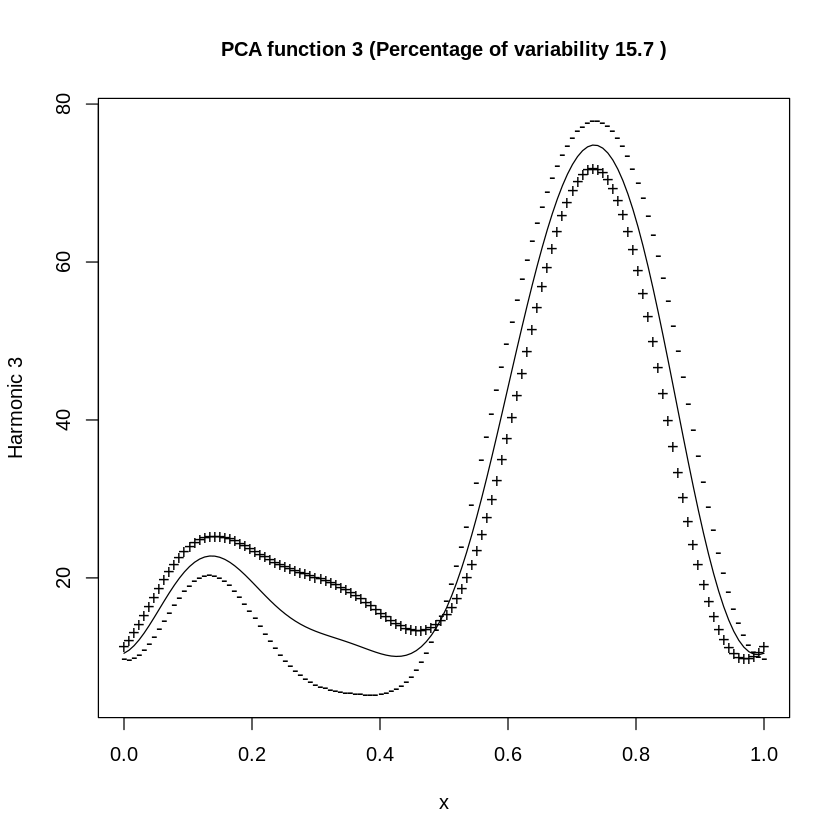

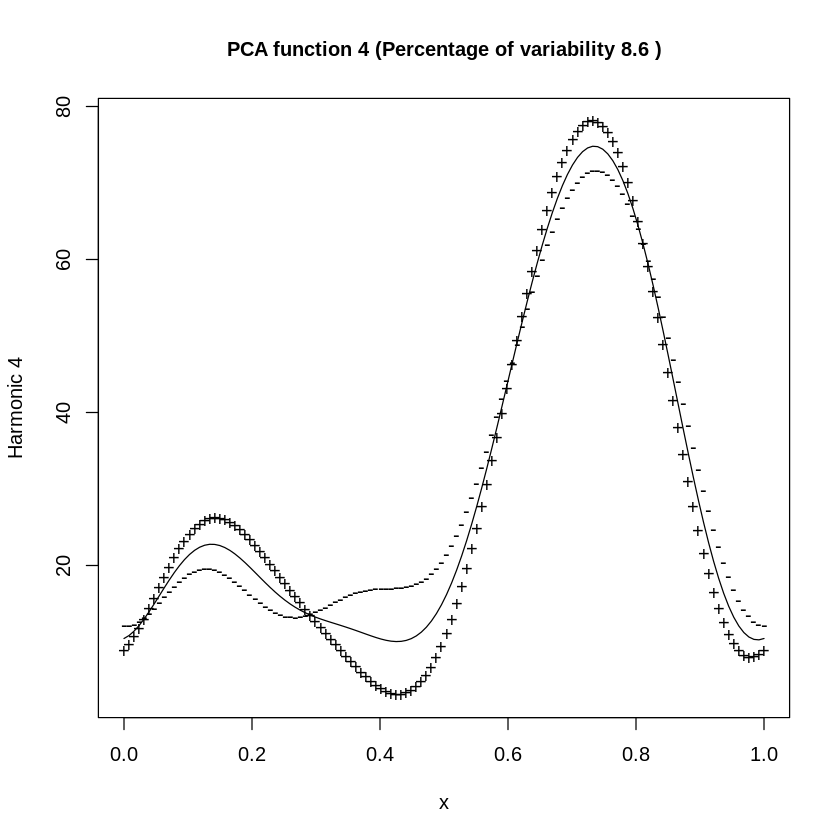

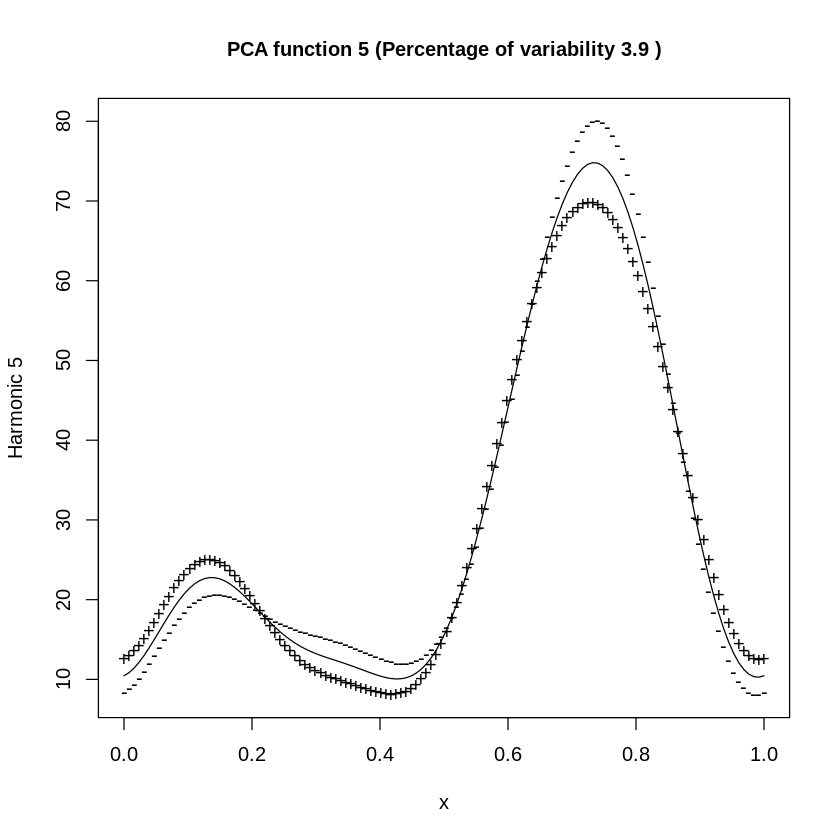

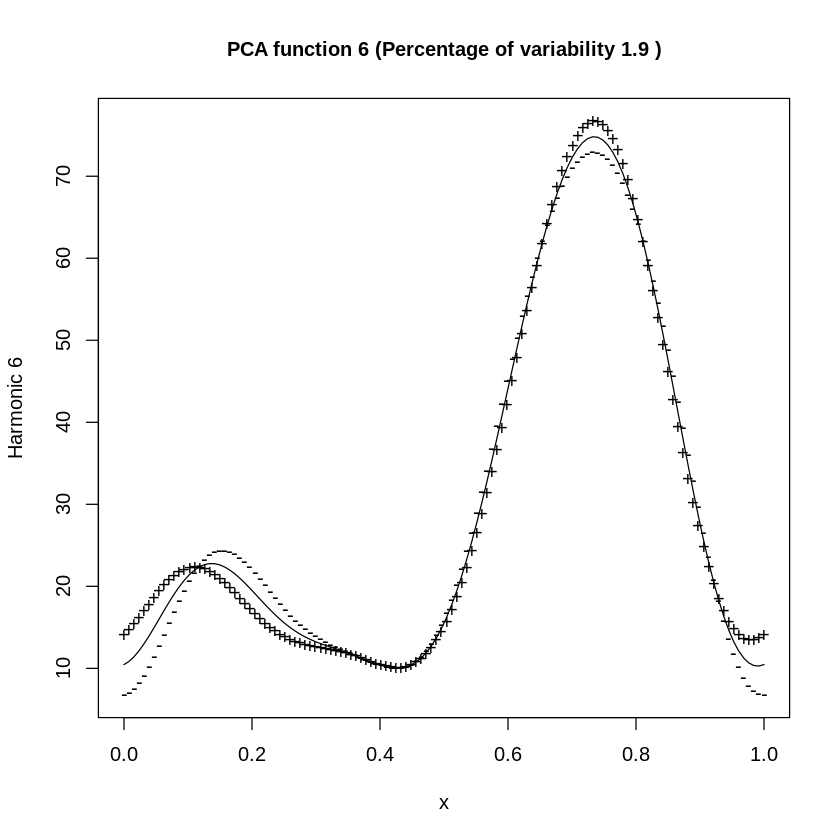

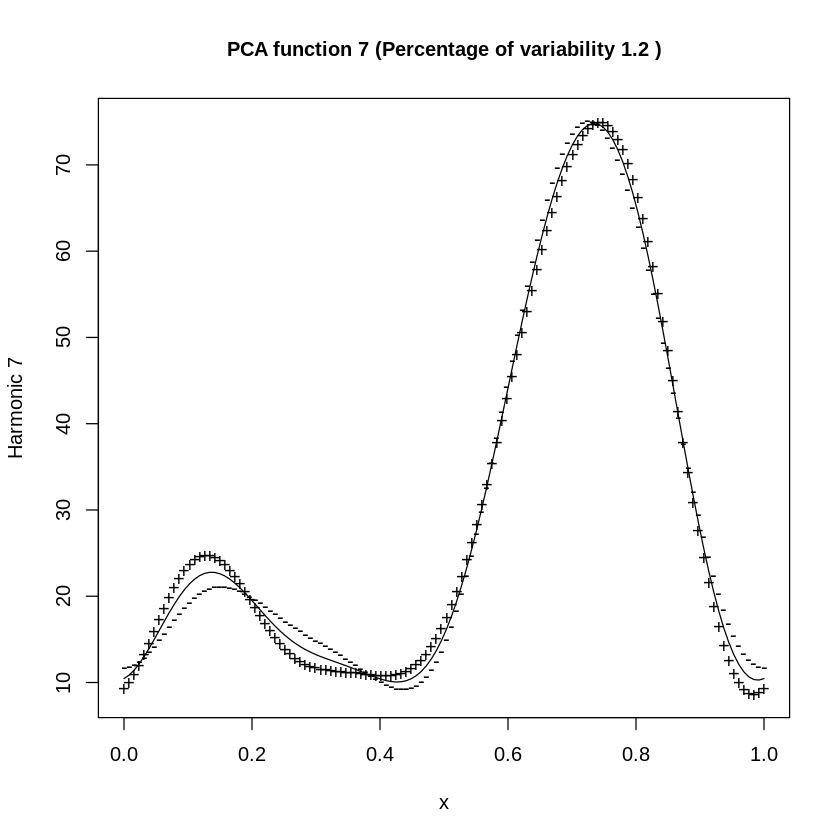

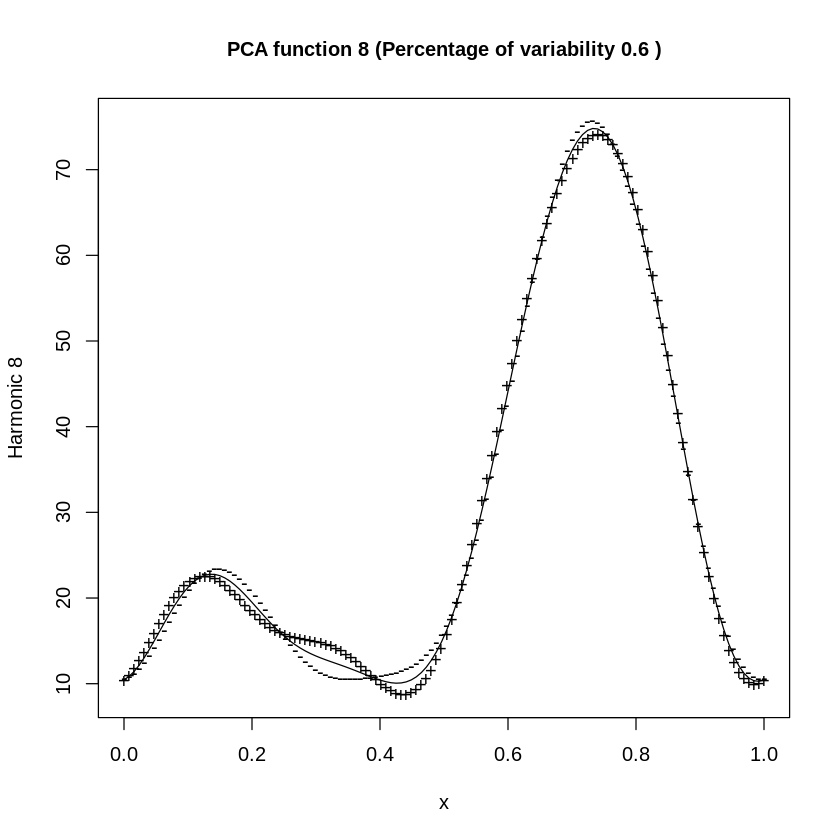

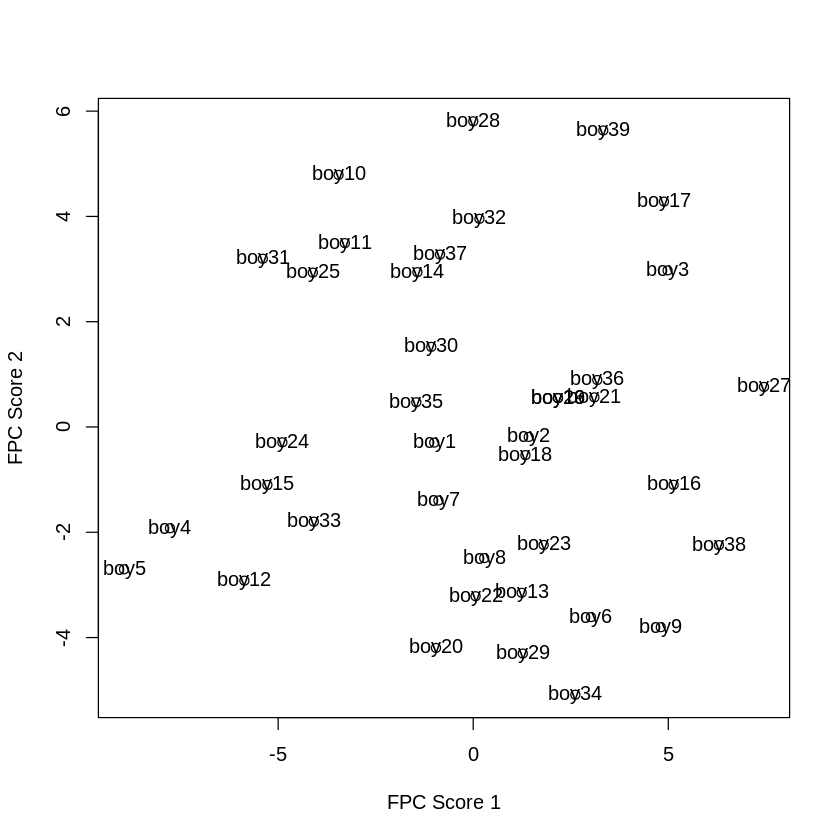

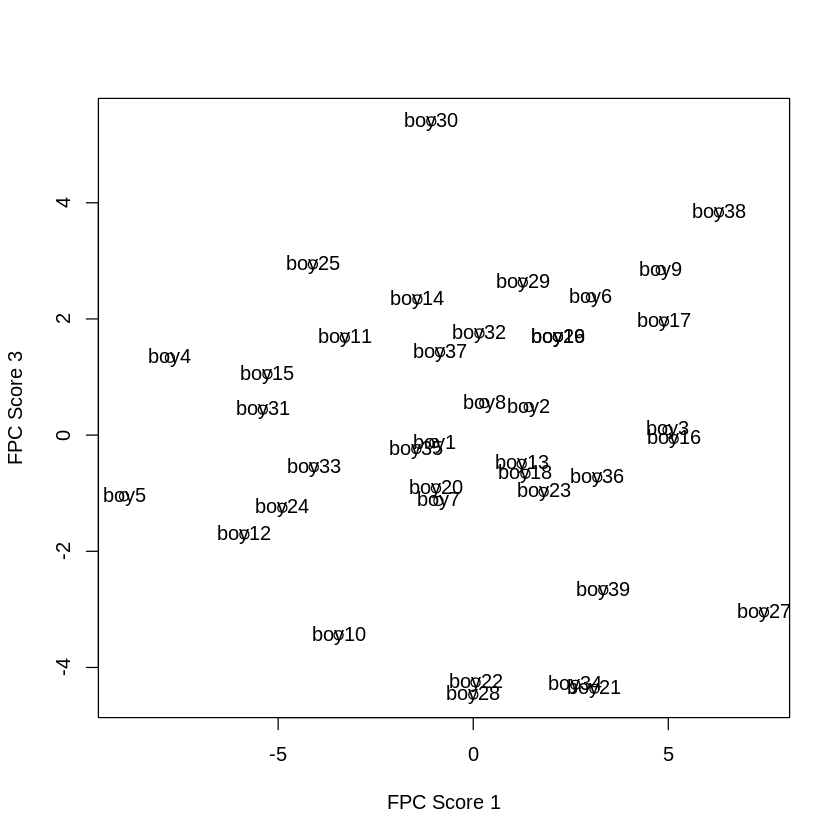

In [21]:
# 6.4 関数主成分分析

library(fda)

# 膝関節データの読み込み
data(gait)
# 元データのプロット(20時点，39人)
matplot(gait[,,2], type="l", xlab="time", ylab="angle")

# 基底関数の作成(フーリエ級数)
# 8つの基底関数を作成
basis.f <- create.fourier.basis(c(0, 1), nbasis=8)
gait.ft <- smooth.basis(dimnames(gait)[[1]], gait[,,2], basis.f) # 基底関数の当てはめ
plot(gait.ft,xlab="time",ylab="angle") # 描画 
lines(mean.fd(gait.ft$fd),lwd=3,col=1) # 平均関数

# 基底関数の作成(B-スプライン関数，8つの基底関数)
# 8つの基底関数を作成(norder=4は3次のスプラインであることを指す) 
basis.b <- create.bspline.basis(c(0,1),nbasis=8, norder=4)
gait.bs <- smooth.basis(dimnames(gait)[[1]], gait[,,2], basis.b)
# 基底関数の当てはめ
plot(gait.bs,xlab="time",ylab="angle") # 描画 
lines(mean.fd(gait.bs$fd),lwd=3,col=1) # 平均関数


# 関数主成分分析の実行
# まず基底関数と同じ数の主成分を求める 
gait.pca <- pca.fd(gait.ft$fd, nharm = 8) 
plot(cumsum(gait.pca$varprop),type="o",xlab='component',ylab='contribution') # 累積寄与率 
plot(gait.pca$harmonics[1:3]) # 固有関数

# 角度パターンの各種成分軸に沿った変化
plot.pca.fd(gait.pca, cex.main=1)
# 主成分得点
plot(gait.pca$scores[,c(1,2)], xlab="FPC Score 1",ylab="FPC Score 2") # PC1-PC2 
text(gait.pca$scores[,c(1,2)],labels=dimnames(gait)[[2]],cex=1)
plot(gait.pca$scores[,c(1,3)], xlab="FPC Score 1",ylab="FPC Score 3")  # PC1-PC3
text(gait.pca$scores[,c(1,3)],labels=dimnames(gait)[[2]],cex=1)